# Data Science Assignment: Web3 Trading Analysis
### Candidate Submission for the Web3 Trading Team

**Objective:** Analyze the alignment and divergence between trader behavior (PnL, Volume) and Bitcoin Market Sentiment (Fear/Greed Index) to identify actionable trading signals.

# 1. Environment Setup, Libraries & Warnings

This section initializes the Python environment, loads all necessary libraries, configures plotting aesthetics for consistency, and implements best practices to suppress non-critical runtime warnings.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import warnings
import gdown
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("Setup complete. Libraries loaded and warnings suppressed.")

Setup complete. Libraries loaded and warnings suppressed.


# 2. Data Acquisition and Initial Load

The two required datasets (Historical Trader Data from Hyperliquid and Bitcoin Market Sentiment Index) are downloaded from Google Drive and loaded into Pandas DataFrames for processing. Output directories (`csv_files/`, `outputs/`) are created to adhere to the submission structure.

In [ ]:


TRADER_ID = '1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs'
SENTIMENT_ID = '1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf'
TRADER_FILE = 'Historical_Trader_Data.csv'
SENTIMENT_FILE = 'Bitcoin_Market_Sentiment.csv'

os.makedirs('csv_files', exist_ok=True)
os.makedirs('outputs', exist_ok=True)
OUTPUTS_DIR = 'outputs'

gdown.download(f'https://drive.google.com/uc?id={TRADER_ID}', TRADER_FILE, quiet=False)
df_trader = pd.read_csv(TRADER_FILE)
print(f"Loaded Trader Data: {TRADER_FILE}")

gdown.download(f'https://drive.google.com/uc?id={SENTIMENT_ID}', SENTIMENT_FILE, quiet=False)
df_sentiment = pd.read_csv(SENTIMENT_FILE)
print(f"Loaded Sentiment Data: {SENTIMENT_FILE}")

print("\nTrader Data Sample (5 rows):")
print(df_trader.sample(5))
print("\nSentiment Data Sample (5 rows):")
print(df_sentiment.sample(5))

Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/Historical_Trader_Data.csv
100%|██████████| 47.5M/47.5M [00:01<00:00, 45.7MB/s]


Loaded Trader Data: Historical_Trader_Data.csv


Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/Bitcoin_Market_Sentiment.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 46.9MB/s]

Loaded Sentiment Data: Bitcoin_Market_Sentiment.csv

Trader Data Sample (5 rows):
                                           Account  Coin  Execution Price  \
149948  0xb899e522b5715391ae1d4f137653e7906c5e2115   SOL         119.2200   
103262  0x8477e447846c758f5a675856001ea72298fd9cb5   ZRO           5.2708   
140407  0x28736f43f1e871e6aa8b1148d38d4994275d72c4   ETH        2143.9000   
184892  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  HYPE          15.6630   
175269  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  HYPE          16.1750   

        Size Tokens  Size USD  Side     Timestamp IST  Start Position  \
149948      15.7800   1881.29   BUY  10-03-2025 22:33      12720.7400   
103262      42.0000    221.37  SELL  22-07-2024 15:32     -19034.2000   
140407       1.4746   3161.39  SELL  05-03-2025 00:25          6.4746   
184892       9.5100    148.96   BUY  26-03-2025 18:57       6949.1500   
175269      12.3600    199.92   BUY  04-03-2025 12:42      16444.6600   

         Directi

# 3. Data Cleaning and Preprocessing

This step ensures data integrity and prepares the features for aggregation:
* **Standardization:** Column names are cleaned (lowercase, standardized).
* **Type Casting:** Date/time columns are converted to proper `datetime` objects.
* **Feature Engineering (Sentiment):** The categorical `classification` (Fear/Greed) is mapped to a numerical `sentiment_score` for correlation analysis.
* **Handling Missing Data:** Entries missing critical trading metrics are dropped.

In [ ]:

df_sentiment.columns = df_sentiment.columns.str.strip().str.lower()
df_trader.columns = df_trader.columns.str.strip().str.lower().str.replace(' ', '_')

if 'date' not in df_sentiment.columns:
    df_sentiment = df_sentiment.reset_index()

df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_sentiment['classification'] = df_sentiment['classification'].str.strip().str.lower()

sentiment_mapping = {'fear': -1, 'greed': 1, 'extreme fear': -2, 'extreme greed': 2}
df_sentiment.loc[:, 'sentiment_score'] = df_sentiment['classification'].map(sentiment_mapping)

df_sentiment = df_sentiment.set_index('date').sort_index()

df_trader.loc[:, 'datetime'] = pd.to_datetime(df_trader['timestamp_ist'], errors='coerce', dayfirst=True)
df_trader.loc[:, 'date'] = df_trader['datetime'].dt.normalize()

df_trader.dropna(subset=['closed_pnl', 'size_usd', 'execution_price'], inplace=True)
df_trader = df_trader.sort_values(by='date')

df_sentiment.info()
df_trader.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2644 entries, 2018-02-01 to 2025-05-02
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        2644 non-null   int64  
 1   value            2644 non-null   int64  
 2   classification   2644 non-null   object 
 3   sentiment_score  2248 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 103.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 211224 entries, 83771 to 14004
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   account           211224 non-null  object        
 1   coin              211224 non-null  object        
 2   execution_price   211224 non-null  float64       
 3   size_tokens       211224 non-null  float64       
 4   size_usd          211224 non-null  float64       
 5   side              211224 non-null  ob

# 4. Feature Engineering and Aggregation

The transaction-level trader data is aggregated into essential **Daily Trading Metrics** and merged with the daily sentiment index to create the final analysis-ready dataset.

| Metric | Calculation | Purpose |
| :--- | :--- | :--- |
| `total_pnl` | Sum of `closed_pnl` | Daily profitability. |
| `total_volume_usd` | Sum of `size_usd` | Daily market activity/volume. |
| `df_merged` | Inner join on 'Date' | Unified dataset for core analysis. |

In [ ]:

print("\n--- Aggregating Trader Data ---")

df_trader_daily = df_trader.groupby('date').agg(
    total_pnl=('closed_pnl', 'sum'),
    total_volume_usd=('size_usd', 'sum'),

).reset_index()

df_trader_daily = df_trader_daily.rename(columns={'date': 'Date'})

print("Daily Trader Metrics Head:")
print(df_trader_daily.head())
print("\nDaily Trader Metrics Info:")
df_trader_daily.info()


--- Aggregating Trader Data ---
Daily Trader Metrics Head:
        Date   total_pnl  total_volume_usd
0 2023-05-01    0.000000            477.00
1 2023-12-05    0.000000          50005.83
2 2023-12-14 -205.434737         113203.35
3 2023-12-15  -24.632034          10609.95
4 2023-12-16    0.000000          15348.77

Daily Trader Metrics Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              480 non-null    datetime64[ns]
 1   total_pnl         480 non-null    float64       
 2   total_volume_usd  480 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 11.4 KB


In [ ]:

print("\n--- Merging Trader and Sentiment Data ---")

df_sentiment_reset = df_sentiment.reset_index().rename(columns={'date': 'Date'})
df_merged = pd.merge(
    df_trader_daily,
    df_sentiment_reset[['Date', 'classification', 'sentiment_score']],
    on='Date',
    how='inner'
)
df_merged['Date'] = pd.to_datetime(df_merged['Date'])
output_path = 'csv_files/processed_trader_sentiment_data.csv'
df_merged.to_csv(output_path, index=False)

print(f"Final processed data saved to: {output_path}")
print(df_merged.head())


print("\nMerged Data Info:")
df_merged.info()


--- Merging Trader and Sentiment Data ---
Final processed data saved to: csv_files/processed_trader_sentiment_data.csv
        Date   total_pnl  total_volume_usd classification  sentiment_score
0 2023-05-01    0.000000            477.00          greed              1.0
1 2023-12-05    0.000000          50005.83  extreme greed              2.0
2 2023-12-14 -205.434737         113203.35          greed              1.0
3 2023-12-15  -24.632034          10609.95          greed              1.0
4 2023-12-16    0.000000          15348.77          greed              1.0

Merged Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              479 non-null    datetime64[ns]
 1   total_pnl         479 non-null    float64       
 2   total_volume_usd  479 non-null    float64       
 3   classification    479 non-null  

###  Total Volume by Sentiment (Bar Chart)

A comparison of total trading volume across different sentiment regimes to identify periods of peak market activity.


--- Volume Analysis vs. Sentiment ---
Total Volume (USD) by Sentiment:
classification
fear             4.833248e+08
greed            2.885825e+08
neutral          1.802421e+08
extreme greed    1.244652e+08
extreme fear     1.144843e+08
Name: total_volume_usd, dtype: float64


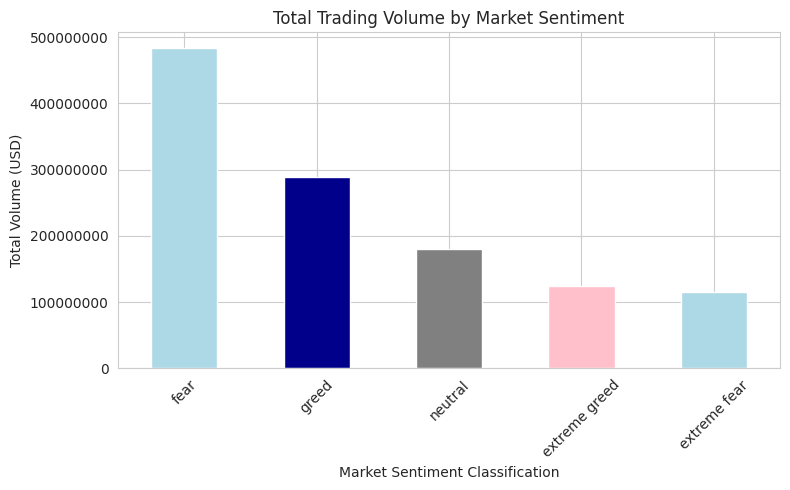

In [ ]:
print("\n--- Volume Analysis vs. Sentiment ---")

volume_by_sentiment = df_merged.groupby('classification')['total_volume_usd'].sum().sort_values(ascending=False)

print("Total Volume (USD) by Sentiment:")
print(volume_by_sentiment)

plt.figure(figsize=(8, 5))
volume_by_sentiment.plot(kind='bar', color=['lightblue', 'darkblue', 'gray', 'pink'])
plt.title('Total Trading Volume by Market Sentiment')
plt.ylabel('Total Volume (USD)')
plt.xlabel('Market Sentiment Classification')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()

plt.savefig(os.path.join(OUTPUTS_DIR,'volume_vs_sentiment.png'))
plt.show()

###  Avg Daily PnL by Sentiment (Bar Chart)

A direct comparison of average daily PnL grouped by sentiment classification.

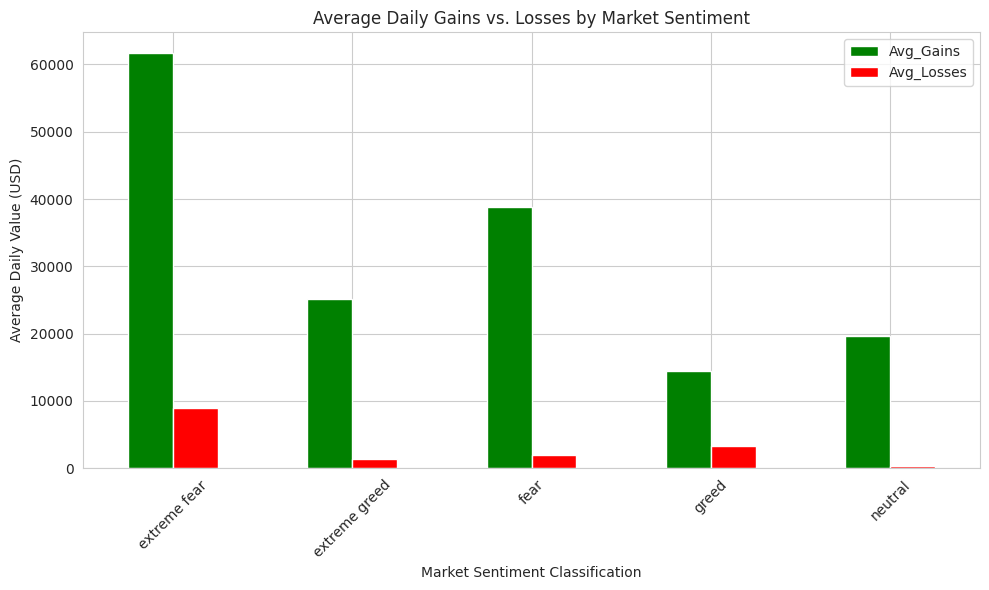

In [ ]:
# Create columns for positive PnL and absolute negative PnL (losses)
df_merged.loc[:, 'gains'] = df_merged['total_pnl'].apply(lambda x: x if x > 0 else 0)
df_merged.loc[:, 'losses'] = df_merged['total_pnl'].apply(lambda x: abs(x) if x < 0 else 0)

pnl_directional = df_merged.groupby('classification').agg(
    Avg_Gains=('gains', 'mean'),
    Avg_Losses=('losses', 'mean')
)

# Plotting the side-by-side comparison
pnl_directional.plot(kind='bar', figsize=(10, 6), color=['green', 'red'])
plt.title('Average Daily Gains vs. Losses by Market Sentiment')
plt.ylabel('Average Daily Value (USD)')
plt.xlabel('Market Sentiment Classification')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR,'directional_pnl_vs_sentiment.png'))
plt.show()

#  Advanced Analysis: Granular & Time-Series Insights

This section moves beyond averages to perform a deeper, more robust analysis of PnL distribution, temporal trends, and directional trading outcomes to uncover hidden trends.


 Hidden Trend Identification (Correlation) ---
Correlation Matrix:
                  sentiment_score  total_pnl  total_volume_usd
sentiment_score          1.000000  -0.103452         -0.294956
total_pnl               -0.103452   1.000000          0.325759
total_volume_usd        -0.294956   0.325759          1.000000


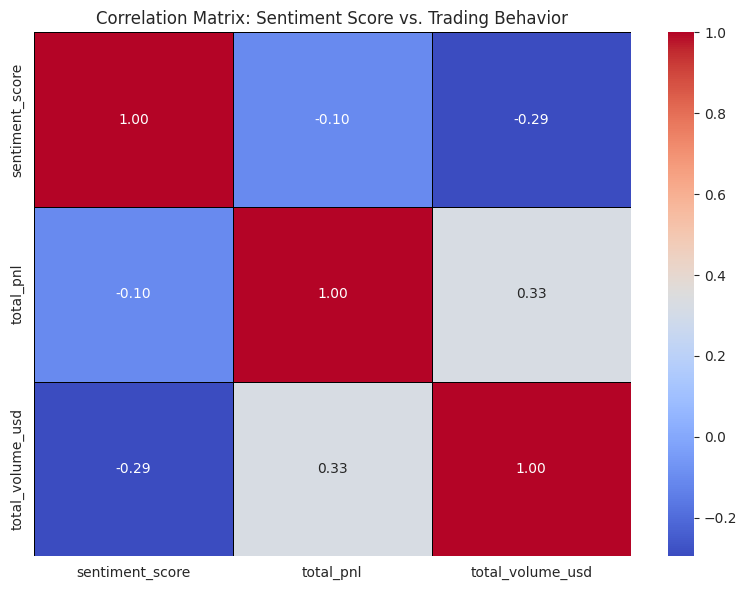

In [ ]:
print("\n Hidden Trend Identification (Correlation) ---")

correlation_matrix = df_merged[['sentiment_score', 'total_pnl', 'total_volume_usd']].corr()

print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black')
plt.title('Correlation Matrix: Sentiment Score vs. Trading Behavior')
plt.tight_layout()

plt.savefig(os.path.join( OUTPUTS_DIR,'correlation_heatmap.png'))
plt.show()

In [ ]:

print("\n--- Lagged Analysis: Feature Engineering ---")

df_merged = df_merged.sort_values(by='Date')

df_merged['lagged_sentiment_score'] = df_merged['sentiment_score'].shift(1)

df_merged = df_merged.dropna(subset=['lagged_sentiment_score'])

print("Merged Data Head with Lagged Sentiment:")
print(df_merged.head())


--- Lagged Analysis: Feature Engineering ---
Merged Data Head with Lagged Sentiment:
        Date   total_pnl  total_volume_usd classification  sentiment_score  \
1 2023-12-05    0.000000          50005.83  extreme greed              2.0   
2 2023-12-14 -205.434737         113203.35          greed              1.0   
3 2023-12-15  -24.632034          10609.95          greed              1.0   
4 2023-12-16    0.000000          15348.77          greed              1.0   
5 2023-12-17  304.982785         116278.02          greed              1.0   

        gains      losses  lagged_sentiment_score  
1    0.000000    0.000000                     1.0  
2    0.000000  205.434737                     2.0  
3    0.000000   24.632034                     1.0  
4    0.000000    0.000000                     1.0  
5  304.982785    0.000000                     1.0  


#  Predictive Analysis: Lagged Sentiment

This step tests the previous day's sentiment as a potential predictive signal for today's trading performance, using the generated `lagged_sentiment_score` to find correlations with current PnL and Volume.


--- Correlation with Lagged Sentiment ---
Correlation of Lagged Sentiment with Current Day Metrics:
lagged_sentiment_score    1.000000
total_pnl                -0.124252
total_volume_usd         -0.299882
Name: lagged_sentiment_score, dtype: float64


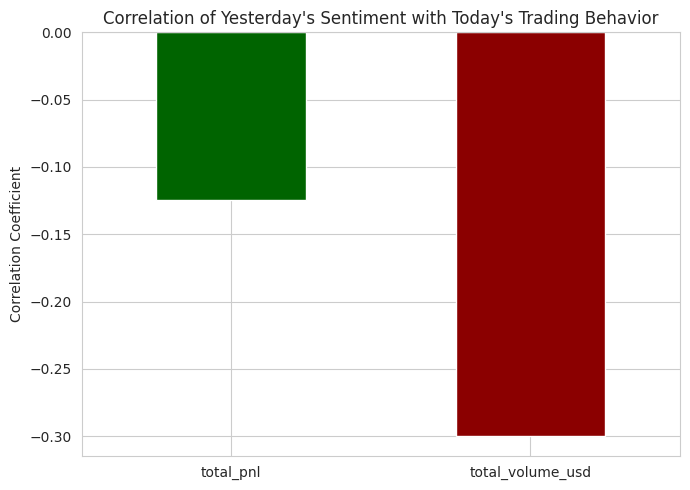

In [ ]:

print("\n--- Correlation with Lagged Sentiment ---")

lagged_correlation = df_merged[['lagged_sentiment_score', 'total_pnl', 'total_volume_usd']].corr().iloc[0]

print("Correlation of Lagged Sentiment with Current Day Metrics:")
print(lagged_correlation)

lagged_correlation = lagged_correlation.drop('lagged_sentiment_score')


plt.figure(figsize=(7, 5))
lagged_correlation.plot(kind='bar', color=['darkgreen', 'darkred'])
plt.title('Correlation of Yesterday\'s Sentiment with Today\'s Trading Behavior')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=0)
plt.axhline(0, color='black', linewidth=0.5)
plt.tight_layout()

plt.savefig(os.path.join( OUTPUTS_DIR,'lagged_correlation.png'))
plt.show()

###  Rolling Averages: Trend Synchronization

This time-series plot uses **7-day rolling averages** to smooth out daily volatility, highlighting underlying long-term trends and identifying potential synchronization or decoupling between trading volume and profitability.

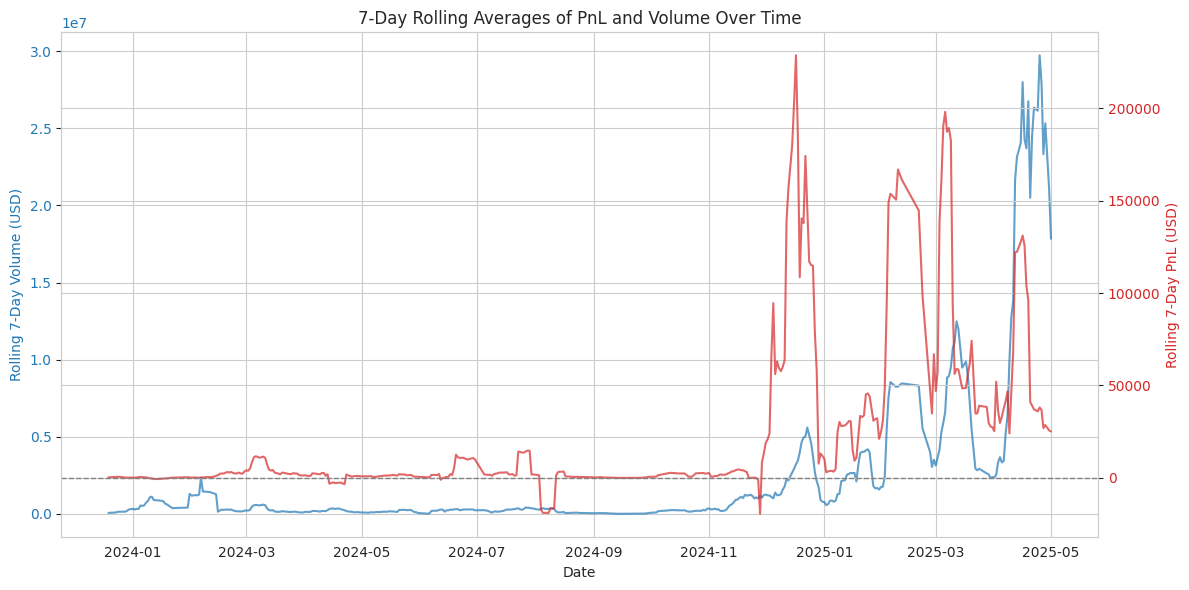

In [ ]:
df_merged = df_merged.sort_values(by='Date')
df_merged.loc[:, 'rolling_pnl'] = df_merged['total_pnl'].rolling(window=7).mean()
df_merged.loc[:, 'rolling_volume'] = df_merged['total_volume_usd'].rolling(window=7).mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling 7-Day Volume (USD)', color=color)
ax1.plot(df_merged['Date'], df_merged['rolling_volume'], color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Rolling 7-Day PnL (USD)', color=color)
ax2.plot(df_merged['Date'], df_merged['rolling_pnl'], color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.title('7-Day Rolling Averages of PnL and Volume Over Time')
fig.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'rolling_trends.png'))
plt.show()